The following is from [this article](https://medium.com/towards-data-science/understanding-predictive-maintenance-wave-data-feature-engineering-part-1-fd22b6a19323) in Medium.

# Vibration data ‚Äî core of predictive maintenance

Understanding vibration data is crucial in predictive maintenance for several reasons. Firstly, abnormal vibrations are often early indicators of machinery malfunctions. By continuously monitoring and analyzing vibration data, maintenance teams can detect anomalies before they lead to critical failures. Secondly, vibration analysis provides insights into the specific nature of a potential issue, allowing for targeted and timely interventions. Lastly, by leveraging vibration data, predictive maintenance strategies can move away from routine, time-based maintenance to a more efficient, condition-based approach, optimizing equipment performance and minimizing downtime.

# Feature Engineering Theory

### Time-Domain Features

In this category, statistical measures such as mean, standard deviation, skewness, and kurtosis are calculated for each vibration signal. Additionally, we delve into metrics like the Root Mean Square (RMS) and Crest Factor to provide overall measures of signal energy and peak characteristics.

- `Distibution Statistical Measures` Calculate statistical measures such as `mean`, `standard deviation`, `skewness`, and `kurtosis` for each vibration signal.

- `RMS (Root Mean Square)` Provides a measure of the overall energy in the signal.

- `Crest Factor` The ratio of the peak value to the RMS value.

### Frequency-Domain Features

Transitioning to the frequency domain, we employ techniques like the `Fast Fourier Transform (FFT)` to convert time-domain signals. Extracted features include `dominant frequency`, `spectral entropy`, and `spectral kurtosis`. `Power Spectral Density (PSD)` offers insights into power distribution and harmonic relationships.

- `FFT (Fast Fourier Transform)` Convert the time-domain signal to the frequency domain. Extract features from the resulting spectrum, such as `dominant frequency`, `spectral entropy`, and `spectral kurtosis`.

- `Power Spectral Density (PSD)` Describes how the power of a signal is distributed over frequency.

### Time-Frequency Features

Exploring the time-frequency domain involves techniques such as the `Wavelet Transform` and `Short-Time Fourier Transform (STFT)`, providing dynamic representations of signals and capturing changes in frequency content over time.

- `Wavelet Transform` Provides a time-frequency representation of the signal. Extract features from the wavelet coefficients.

- `Short-Time Fourier Transform (STFT)` Represents how the frequency content of a signal changes over time.

### Envelope Analysis

Demodulation techniques, such as the `Hilbert transform` or `wavelet transform`, are employed to extract signal envelopes. Analyzing features within the envelope adds another layer of understanding.

- `Demodulation` Extract the envelope of the signal using techniques like `Hilbert transform` or `wavelet transform`. Analyze the features of the envelope.

### Statistical Measures Over Windows

Rolling statistics, computed over fixed-size windows, allow the capture of trends and patterns. Additionally, higher-order statistical moments over windows, known as waveform moments, contribute valuable insights.

- `Rolling Statistics` Calculate statistical measures over fixed-size windows, capturing trends and patterns.

- `Waveform Moments` Higher-order statistical moments over windows.

### Recurrence Plots

Delving into recurrence plots and utilizing `Recurrence Quantification Analysis (RQA)` them allows discerning patterns in the data structure, providing a unique perspective on vibration signals.

- `Recurrence Quantification Analysis (RQA)` Analyze the structure of the recurrence plot to capture patterns in the data.

### Domain-Specific Features

Domain-specific features, such as `Peak Features` and `Shape Features`, are designed to identify and analyze peaks and the overall waveform shape in vibration signals.

- `Peak Features` Identify and analyze peaks in the vibration signal.

- `Shape Features` Extract features related to the shape of the signal waveform.

While these examples don‚Äôt encompass every possibility, some of them might prove useful for your needs. :)

# Hand's on experience

### Create the signal for experiments

We need to emulate the vibration signal and add more realism to reproduce the equipment wear

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def generate_vibration_signal(
    duration, sampling_rate, frequency, amplitude, noise_level, max_wear, wear_threshold
):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

    # Generate a sinusoidal signal
    signal = amplitude * np.sin(2 * np.pi * frequency * t)

    # Add random noise to simulate real-world conditions
    noise = np.random.normal(0, noise_level, signal.shape)
    signal_with_noise = signal + noise

    # Simulate equipment wear
    wear = np.linspace(0, max_wear, len(t))
    wear[wear > wear_threshold] = 0  # Reset wear if it exceeds the threshold
    signal_with_wear = signal_with_noise + wear

    return t, signal_with_wear

In this code, the wear is resetting after reaching specific value -simulation of equipment change

Let's generate the signal and plot

In [3]:
# Parameters
duration = 20  # seconds
sampling_rate = 20  # Hz
frequency = 5  # Hz (vibration frequency)
amplitude = 1.0  # Min Max range
noise_level = 0.3  # Noise factor to increase reality
max_wear = 1  # Maximum wear before reset
wear_threshold = 0.5  # Wear threshold for reset

In [4]:
# Generate synthetic vibration signal with wear and threshold
time, vibration_signal = generate_vibration_signal(
    duration, sampling_rate, frequency, amplitude, noise_level, max_wear, wear_threshold
)

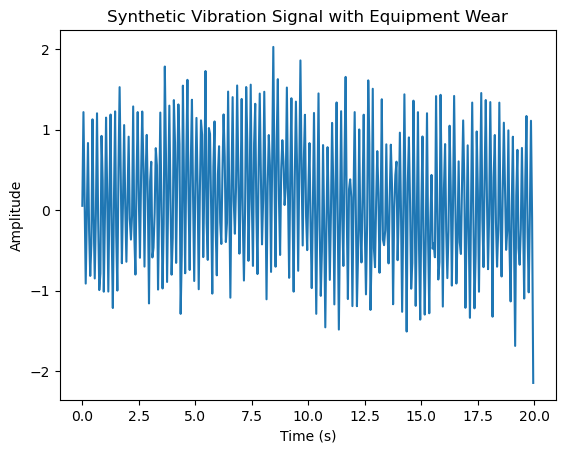

In [5]:
# Plot the signal
plt.plot(time, vibration_signal)
plt.title("Synthetic Vibration Signal with Equipment Wear")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
# plt.legend()
plt.show();

This article‚Äôs mission is to introduce you to these cool features. We‚Äôre not building the whole process here ‚Äî no pipelines for us today. That‚Äôs a story for another article! Right now, let‚Äôs dive into the fun world of creating features from signals. Ready for the feature-fest? Let‚Äôs roll! üöÄ

### To window or not to window, that is the question.

Time series windowing is like looking at snapshots of a continuous timeline, and it‚Äôs super helpful, especially in predictive maintenance. Imagine you‚Äôre watching a movie, but instead of watching the whole thing, you pause every few minutes and take a picture. These pictures are your ‚Äúwindows.‚Äù Now, these windows help us understand how things change over time. In the world of machines and equipment, where things can wear out or break, understanding how they behaved in the past helps us predict what might happen in the future.

One big plus of using these windows is that they make it easier to understand what‚Äôs going on. It‚Äôs like breaking down a big story into smaller chapters. Each window is a chapter, and by looking at them, we can spot any weird or interesting things that happened in that time frame. This detailed view helps us figure out why machines might be getting worn out or failing. Also, these windows help us deal with changes in how often we get information and handle any weird stuff in the data, making sure our predictions are solid.

But, of course, it‚Äôs not all sunshine and rainbows. Picking the right size for these windows is a bit tricky. If they‚Äôre too big or too small, we might miss important details or add in unnecessary noise. It‚Äôs like choosing the right lens for your camera ‚Äî you want to capture just the right amount. Also, deciding whether these windows should overlap or not is a bit of a puzzle. Overlapping windows give more context, but too much overlap might make things repetitive. It‚Äôs like trying to balance how much backstory to include in each chapter of a book. Finding this sweet spot is key to making sure our predictions about machine maintenance are spot on.

### Windowing example

In [6]:
df_windowed = pd.DataFrame({"time": time, "vibration_signal": vibration_signal})

In [7]:
df_windowed

time  vibration_signal
0     0.00          0.053460
1     0.05          1.216912
2     0.10          0.135020
3     0.15         -0.912267
4     0.20         -0.046803
..     ...               ...
395  19.75         -1.020986
396  19.80         -0.075341
397  19.85          1.109670
398  19.90         -0.104534
399  19.95         -2.146125

[400 rows x 2 columns]

I‚Äôm going to throw a window party with different sizes to show you how it changes things up. It‚Äôs like Mean Windowing is our cool DJ, spinning averages within the window range. Let‚Äôs see how the dance floor of data grooves to the beat of different window sizes!

In [8]:
# Make some experiments
window_size = 2

In [9]:
# Apply mean windowing using the 'rolling' function
df_windowed["mean_amplitude"] = (
    df_windowed["vibration_signal"].rolling(window=window_size, min_periods=1).mean()
)

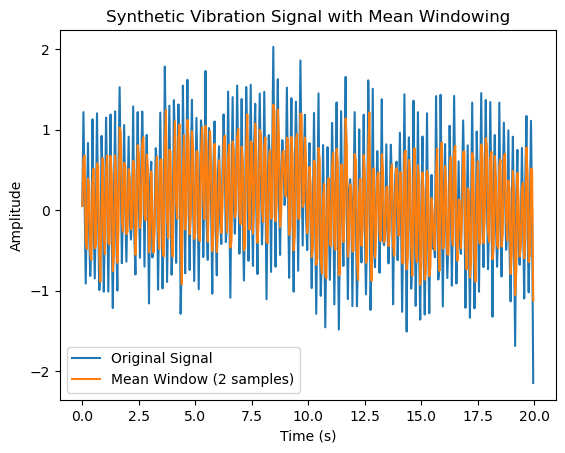

In [10]:
# Plot the original signal and the mean windowed signal
plt.plot(df_windowed["time"], df_windowed["vibration_signal"], label="Original Signal")
plt.plot(
    df_windowed["time"],
    df_windowed["mean_amplitude"],
    label=f"Mean Window ({window_size} samples)",
)
plt.title("Synthetic Vibration Signal with Mean Windowing")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

With a window size of 2, it‚Äôs tough to see any clear patterns; it introduces too much noise. We need to increase the window size to get a better picture of what‚Äôs happening in the data.

In [11]:
# Make some experiments
window_size = 200

In [12]:
# Apply mean windowing using the 'rolling' function
df_windowed["mean_amplitude"] = (
    df_windowed["vibration_signal"].rolling(window=window_size, min_periods=1).mean()
)

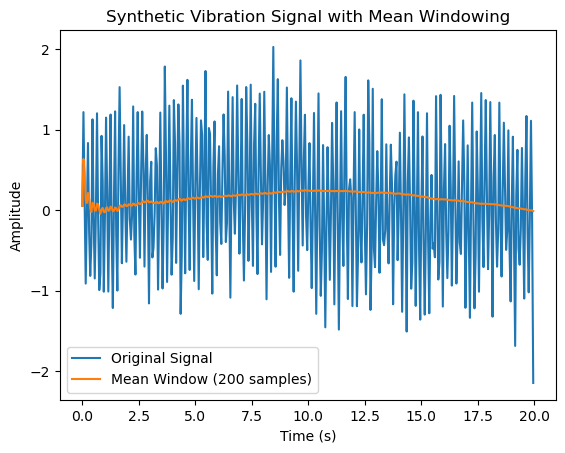

In [13]:
# Plot the original signal and the mean windowed signal
plt.plot(df_windowed["time"], df_windowed["vibration_signal"], label="Original Signal")
plt.plot(
    df_windowed["time"],
    df_windowed["mean_amplitude"],
    label=f"Mean Window ({window_size} samples)",
)
plt.title("Synthetic Vibration Signal with Mean Windowing")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

Right now, the window is too big, and that‚Äôs not good because we‚Äôre losing a lot of details from the data. We want a window that‚Äôs just right to catch all the important stuff.

In [14]:
# Make some experiments
window_size = 20

In [15]:
# Apply mean windowing using the 'rolling' function
df_windowed["mean_amplitude"] = (
    df_windowed["vibration_signal"].rolling(window=window_size, min_periods=1).mean()
)

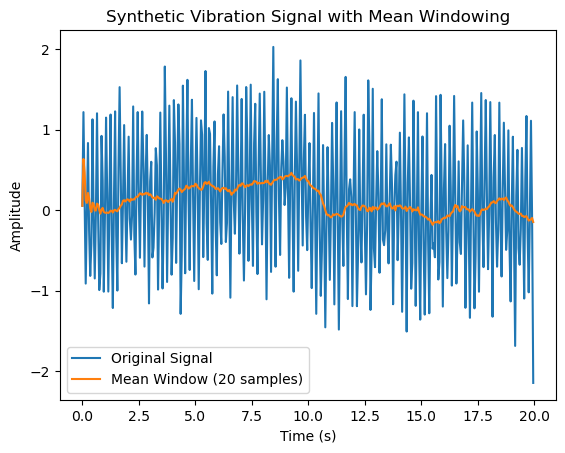

In [16]:
# Plot the original signal and the mean windowed signal
plt.plot(df_windowed["time"], df_windowed["vibration_signal"], label="Original Signal")
plt.plot(
    df_windowed["time"],
    df_windowed["mean_amplitude"],
    label=f"Mean Window ({window_size} samples)",
)
plt.title("Synthetic Vibration Signal with Mean Windowing")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

With a window size of 20, the data pattern becomes distinctly visible, allowing us to discern the synthetic ‚Äúwear effect‚Äù that was introduced during signal generation. When training your models, it‚Äôs essential to engage in trial and error to identify the optimal window size. For the purpose of this article, I will generate features by employing a window size of 20.

### Time-Domain Features

#### Mean

Imagine you and your friends are at a pizza party. Everyone loves pizza with various toppings. This `mean` is like figuring out the average number of pepperoni slices each person has on their pizza. If one friend has a lot and another friend has just a few, the `mean` helps you know how much pepperoni to expect per person on average. It‚Äôs like finding the pizza harmony!

#### Standard Deviation

Now, let‚Äôs talk about `standard deviation`. Picture a group of cats. Some cats are super chill and lazy, while others are hyperactive and playful. This `standard deviation` is like measuring how much each cat‚Äôs energy level deviates or differs from the average energy level of all the cats. If the standard deviation is high, you‚Äôve got a mix of lazy and hypercats. If it‚Äôs low, most of the cats have similar energy levels ‚Äî maybe a laid-back cat party!

#### Skewness

Let‚Äôs use a fruit basket scenario to understand the difference between positive and negative skewness more clearly.

- `Positive Skewness (Fruitful to the Right)` Imagine your friends are filling a fruit basket. Most friends decide to add a variety of fruits, but a couple of them go all out, adding extra bananas, apples, and oranges. The fruit basket seesaw tilts to the right because of this extra fruity enthusiasm. This is `positive skewness`, indicating that there‚Äôs an extended excitement toward more in the right direction.

- `Negative Skewness (Light to the Left)` Now, suppose a few friends decide to keep it light, adding only a few grapes and berries to the basket. The seesaw tilts to the left because of this lighter fruity approach. This is `negative skewness`, signaling a leaning towards less in the left direction.

#### Kurtosis

Now, imagine you‚Äôre on a rollercoaster. Some rollercoasters are wild and full of twists, while others are gentler. `Kurtosis` is our rollercoaster critic, assessing how crazy the ride is. `Positive kurtosis` means the rollercoaster has sharp turns and unexpected loops while `negative kurtosis` suggesting a smoother, milder ride. `Kurtosis` is the thrill factor of our statistical theme park!

### Skewness comparison

In [17]:
from scipy.stats import kurtosis, skew

In [18]:
# Set a random seed for reproducibility
np.random.seed(1992)

In [19]:
# Generate synthetic datasets with varying skewness and kurtosis
# Normal distribution
normal_data = np.random.normal(loc=170, scale=5, size=1000)

# Positively skewed distribution
skewed_data = np.random.gamma(shape=2, scale=5, size=1000)

# Negatively skewed distribution
negative_skewed_data = -np.random.gamma(shape=2, scale=5, size=1000)

In [20]:
# Calculate mean and median for each dataset
normal_mean, normal_median = np.mean(normal_data), np.median(normal_data)
skewed_mean, skewed_median = np.mean(skewed_data), np.median(skewed_data)
negative_skewed_mean, negative_skewed_median = np.mean(negative_skewed_data), np.median(
    negative_skewed_data
)

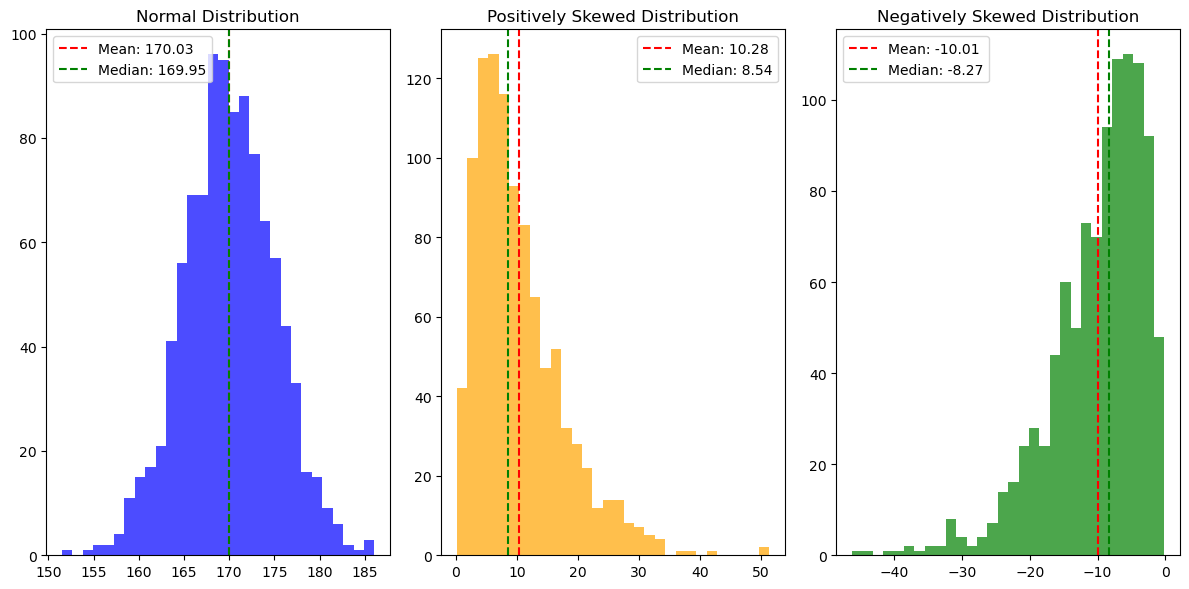

In [21]:
# Plot the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(normal_data, bins=30, color="blue", alpha=0.7)
plt.axvline(
    x=normal_mean, color="red", linestyle="--", label=f"Mean: {normal_mean:.2f}"
)
plt.axvline(
    x=normal_median, color="green", linestyle="--", label=f"Median: {normal_median:.2f}"
)
plt.legend()
plt.title("Normal Distribution")

plt.subplot(1, 3, 2)
plt.hist(skewed_data, bins=30, color="orange", alpha=0.7)
plt.axvline(
    x=skewed_mean, color="red", linestyle="--", label=f"Mean: {skewed_mean:.2f}"
)
plt.axvline(
    x=skewed_median, color="green", linestyle="--", label=f"Median: {skewed_median:.2f}"
)
plt.legend()
plt.title("Positively Skewed Distribution")

plt.subplot(1, 3, 3)
plt.hist(negative_skewed_data, bins=30, color="green", alpha=0.7)
plt.axvline(
    x=negative_skewed_mean,
    color="red",
    linestyle="--",
    label=f"Mean: {negative_skewed_mean:.2f}",
)
plt.axvline(
    x=negative_skewed_median,
    color="green",
    linestyle="--",
    label=f"Median: {negative_skewed_median:.2f}",
)
plt.legend()
plt.title("Negatively Skewed Distribution")

plt.tight_layout()
plt.show()

`Normal` distributions have data spread evenly on both sides, with the mean closely aligned with the median.

`Positive / Right-skewed` distributions have a longer or fatter tail on the right side, indicating more data points on the left. The mean is typically greater than the median

`Negative / Left-skewed` distributions have a longer or fatter tail on the left side, suggesting more data points on the right. The mean is usually less than the median.

### Kurtosis comparison

In [22]:
# Leptokurtic distribution (heavier tails)
heavy_tails_data = np.random.exponential(scale=10, size=1000)

In [23]:
# Platykurtic distribution (lighter tails)
light_tails_data = np.random.uniform(low=160, high=180, size=1000)

In [24]:
# Calculate mean and median for each dataset
normal_mean, normal_median = np.mean(normal_data), np.median(normal_data)
heavy_tails_mean, heavy_tails_median = np.mean(heavy_tails_data), np.median(
    heavy_tails_data
)
light_tails_mean, light_tails_median = np.mean(light_tails_data), np.median(
    light_tails_data
)

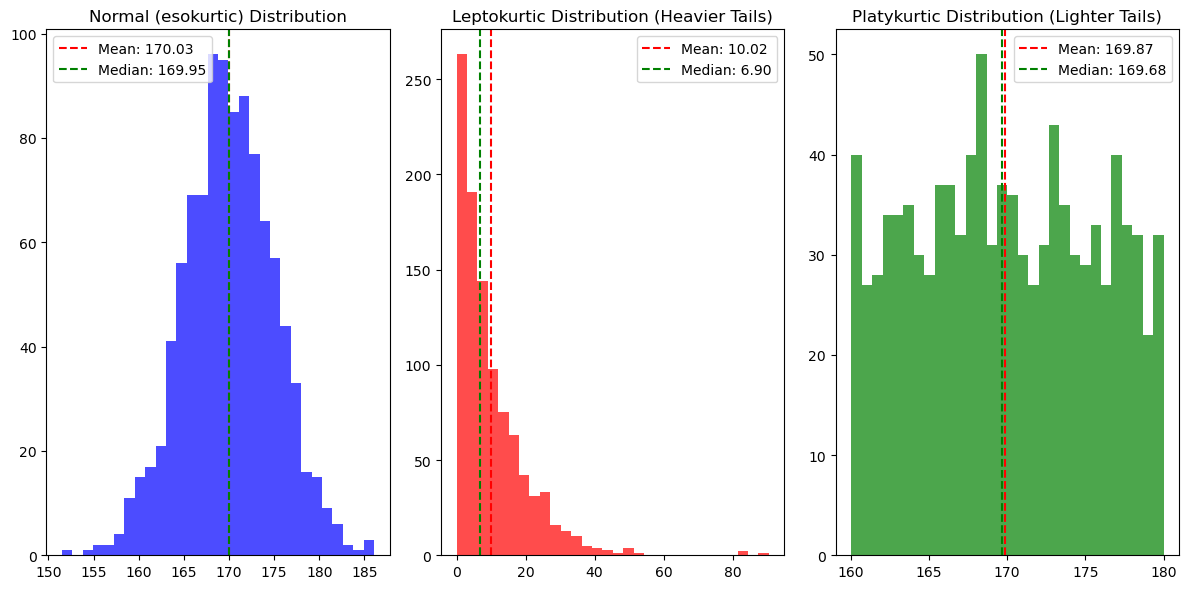

In [25]:
# Plot the distributions with mean and median
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(normal_data, bins=30, color="blue", alpha=0.7)
plt.axvline(
    x=normal_mean, color="red", linestyle="--", label=f"Mean: {normal_mean:.2f}"
)
plt.axvline(
    x=normal_median, color="green", linestyle="--", label=f"Median: {normal_median:.2f}"
)
plt.legend()
plt.title("Normal (esokurtic) Distribution")

plt.subplot(1, 3, 2)
plt.hist(heavy_tails_data, bins=30, color="red", alpha=0.7)
plt.axvline(
    x=heavy_tails_mean,
    color="red",
    linestyle="--",
    label=f"Mean: {heavy_tails_mean:.2f}",
)
plt.axvline(
    x=heavy_tails_median,
    color="green",
    linestyle="--",
    label=f"Median: {heavy_tails_median:.2f}",
)
plt.legend()
plt.title("Leptokurtic Distribution (Heavier Tails)")

plt.subplot(1, 3, 3)
plt.hist(light_tails_data, bins=30, color="green", alpha=0.7)
plt.axvline(
    x=light_tails_mean,
    color="red",
    linestyle="--",
    label=f"Mean: {light_tails_mean:.2f}",
)
plt.axvline(
    x=light_tails_median,
    color="green",
    linestyle="--",
    label=f"Median: {light_tails_median:.2f}",
)
plt.legend()
plt.title("Platykurtic Distribution (Lighter Tails)")

plt.tight_layout()
plt.show()

Now, let‚Äôs compute the statistics for comparison.

In [26]:
# Calculate skewness and kurtosis for each dataset
normal_skewness = skew(normal_data)
normal_kurtosis = kurtosis(normal_data)

skewed_skewness = skew(skewed_data)
skewed_kurtosis = kurtosis(skewed_data)

negative_skewness = skew(negative_skewed_data)
negative_kurtosis = kurtosis(negative_skewed_data)

heavy_tails_skewness = skew(heavy_tails_data)
heavy_tails_kurtosis = kurtosis(heavy_tails_data)

light_tails_skewness = skew(light_tails_data)
light_tails_kurtosis = kurtosis(light_tails_data)

In [27]:
# Print the calculated values
print("Normal Distribution:")
print(f"Skewness: {normal_skewness}, Kurtosis: {normal_kurtosis}\n")

print("Positively Skewed Distribution:")
print(f"Skewness: {skewed_skewness}, Kurtosis: {skewed_kurtosis}\n")

print("Negatively Skewed Distribution:")
print(f"Skewness: {negative_skewness}, Kurtosis: {negative_kurtosis}\n")

print("Leptokurtic Distribution (Heavier Tails):")
print(f"Skewness: {heavy_tails_skewness}, Kurtosis: {heavy_tails_kurtosis}\n")

print("Platykurtic Distribution (Lighter Tails):")
print(f"Skewness: {light_tails_skewness}, Kurtosis: {light_tails_kurtosis}\n")

Normal Distribution:
Skewness: -0.023747118662200778, Kurtosis: 0.13562505575972805

Positively Skewed Distribution:
Skewness: 1.3753017138403605, Kurtosis: 2.735797911478558

Negatively Skewed Distribution:
Skewness: -1.3357153593369862, Kurtosis: 2.4060280852590727

Leptokurtic Distribution (Heavier Tails):
Skewness: 2.344310371944749, Kurtosis: 9.967493010181288

Platykurtic Distribution (Lighter Tails):
Skewness: 0.024237350132264072, Kurtosis: -1.1455613412248278



#### Normal Distribution

- `Skewness` -0.0237 (slightly negatively skewed)
- `Kurtosis` 0.1356 (platykurtic, flatter than normal)

#### Positively Skewed Distribution

- `Skewness` 1.3753 (strongly positively skewed)
- `Kurtosis` 2.7358 (leptokurtic, heavier tails than normal)

#### Negatively Skewed Distribution

- `Skewness` -1.3357 (strongly negatively skewed)
- `Kurtosis` 2.4060 (leptokurtic, heavier tails than normal)

#### Leptokurtic Distribution (Heavier Tails)

- `Skewness` 1.8463 (positively skewed)
- `Kurtosis` 4.4461 (high kurtosis, very heavy tails)

#### Platykurtic Distribution (Lighter Tails)

- `Skewness` -0.0243 (slightly negatively skewed)
- `Kurtosis` -1.1587 (platykurtic, much lighter tails than normal)

### Apply the statistics using the rolling window

In [28]:
def calculate_rolling_statistics(signal, window_size):
    df = pd.DataFrame({"signal": signal})
    rolling_stats = df["signal"].rolling(window=window_size, min_periods=1)

    mean_values = rolling_stats.mean()
    std_dev_values = rolling_stats.std()
    skewness_values = rolling_stats.apply(skew, raw=True)
    kurtosis_values = rolling_stats.apply(kurtosis, raw=True)

    return mean_values, std_dev_values, skewness_values, kurtosis_values

In [29]:
window_size = 20

# Calculate rolling statistics
(
    rolling_means,
    rolling_std_devs,
    rolling_skewness,
    rolling_kurtosis,
) = calculate_rolling_statistics(vibration_signal, window_size)

C:\Users\user\AppData\Local\miniconda3\envs\ls_env\lib\site-packages\pandas\core\window\rolling.py:1449: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return window_func(values, begin, end, min_periods)


And plot the results I will separate skewnes and kurtosis for better visibility

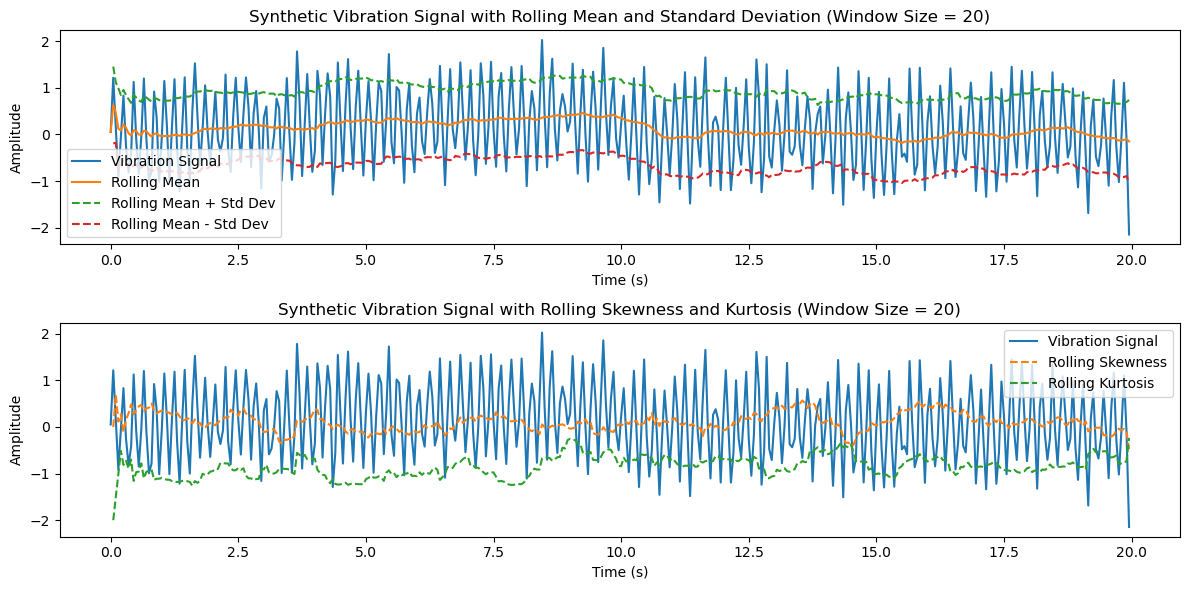

In [30]:
# Plot the signal and rolling statistics
plt.figure(figsize=(12, 6))

# Plot Rolling Mean, Rolling Mean + Std Dev, Rolling Mean - Std Dev
plt.subplot(2, 1, 1)
plt.plot(
    time[: len(rolling_means)],
    vibration_signal[: len(rolling_means)],
    label="Vibration Signal",
)
plt.plot(time[: len(rolling_means)], rolling_means, label="Rolling Mean")
plt.plot(
    time[: len(rolling_means)],
    rolling_means + rolling_std_devs,
    label="Rolling Mean + Std Dev",
    linestyle="--",
)
plt.plot(
    time[: len(rolling_means)],
    rolling_means - rolling_std_devs,
    label="Rolling Mean - Std Dev",
    linestyle="--",
)
plt.title(
    f"Synthetic Vibration Signal with Rolling Mean and Standard Deviation (Window Size = {window_size})"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Plot Rolling Skewness and Rolling Kurtosis
plt.subplot(2, 1, 2)
plt.plot(
    time[: len(rolling_means)],
    vibration_signal[: len(rolling_means)],
    label="Vibration Signal",
)
plt.plot(
    time[: len(rolling_means)],
    rolling_skewness,
    label="Rolling Skewness",
    linestyle="--",
)
plt.plot(
    time[: len(rolling_means)],
    rolling_kurtosis,
    label="Rolling Kurtosis",
    linestyle="--",
)
plt.title(
    f"Synthetic Vibration Signal with Rolling Skewness and Kurtosis (Window Size = {window_size})"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

Observing the results, it‚Äôs evident that the rolling window serves as an effective denoising technique. I suggest experimenting with various window sizes, as Data Science often involves empirical exploration through trial and error.

### Behind the `.apply()` scenes

Here‚Äôs a little extra something to show you how the function and windowing play together in backstage. I‚Äôll do it just this once to give you a peek into how the apply function does its thing when it comes to windowing, using our straightforward examples.

In [31]:
def calculate_rolling_statistics_behind_scenes(signal, window_size):
    mean_values = np.convolve(signal, np.ones(window_size) / window_size, mode="valid")
    std_dev_values = np.array(
        [
            np.std(signal[i - window_size + 1 : i + 1])
            for i in range(window_size - 1, len(signal))
        ]
    )
    skewness_values = np.array(
        [
            skew(signal[i - window_size + 1 : i + 1])
            for i in range(window_size - 1, len(signal))
        ]
    )
    kurtosis_values = np.array(
        [
            kurtosis(signal[i - window_size + 1 : i + 1])
            for i in range(window_size - 1, len(signal))
        ]
    )

    return mean_values, std_dev_values, skewness_values, kurtosis_values

- `mean_values` This is calculated using the `np.convolve` function, which performs a convolution operation. In this case, it calculates the rolling mean by convolving the signal with a window of ones divided by the window size. The `mode='valid'` argument ensures that the convolution is performed only where the full window can fit without zero-padding.

- `std_dev_values` This is calculated by iterating over the signal using a list comprehension. For each position `i` in the signal, it computes the standard deviation of the subarray `signal[i-window_size+1:i+1]`. This represents the rolling standard deviation.

- `skewness_values` Similar to standard deviation, it's computed by iterating over the signal using a list comprehension. For each position `i`, it calculates the skewness of the subarray `signal[i-window_size+1:i+1]`.

- `kurtosis_values` Again, similar to standard deviation and skewness, it's computed by iterating over the signal using a list comprehension. For each position `i`, it calculates the kurtosis of the subarray `signal[i-window_size+1:i+1]`.

### RMS (Root Mean Square)

`Root Mean Square (RMS)` is like a mathematical superhero. It takes a group of numbers, squares each one, finds the average, and then takes the square root. This process gives you a single number that represents the typical size or intensity of the original numbers. It‚Äôs a handy tool in various fields, from measuring vibrations in machinery to assessing the power of signals.

In [32]:
def calculate_rolling_rms(signal, window_size):
    df = pd.DataFrame({"signal": signal})
    rolling_stats = df["signal"].rolling(window=window_size, min_periods=1)

    rms_values = np.sqrt(rolling_stats.apply(lambda x: np.mean(x**2), raw=True))

    return rms_values

In [33]:
window_size = 20
rolling_rms = calculate_rolling_rms(vibration_signal, window_size)

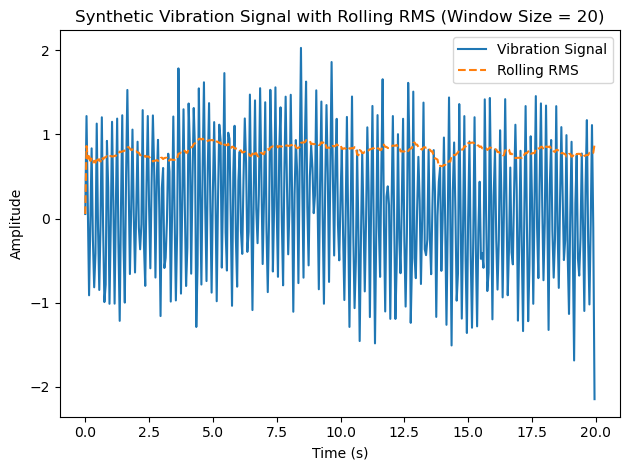

In [34]:
plt.plot(
    time[: len(rolling_rms)],
    vibration_signal[: len(rolling_rms)],
    label="Vibration Signal",
)
plt.plot(time[: len(rolling_rms)], rolling_rms, label="Rolling RMS", linestyle="--")
plt.title(f"Synthetic Vibration Signal with Rolling RMS (Window Size = {window_size})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

RMS unveils a single, robust metric that captures the underlying signal power while effectively mitigating noise. This plot serves as a visual testament to the practical efficacy of RMS in enhancing signal clarity and precision across diverse applications.

### Crest Factor

`Crest Factor (CF)` is like the sidekick `Root Mean Square (RMS)` in the world of signal analysis. While `RMS` it gives you the overall intensity, `Crest Factor` it steps in to highlight the peaks. It‚Äôs the ratio of the highest point to the RMS value, telling you how spiky or ‚Äòcresty‚Äô your signal is. Think of `CF` as the superhero partner that helps you understand the sharp peaks in your data, whether it‚Äôs in sound waves, electrical signals, or any other fluctuating measurements. Together with, they form a dynamic duo for unraveling the secrets hidden in your data.

In [35]:
def calculate_crest_factor_and_peak(signal, window_size):
    df = pd.DataFrame({"signal": signal})
    rolling_stats = df["signal"].rolling(window=window_size, min_periods=1)

    peak_values = rolling_stats.apply(lambda x: np.max(np.abs(x)), raw=True)
    rms_values = np.sqrt(rolling_stats.apply(lambda x: np.mean(x**2), raw=True))

    crest_factor_values = peak_values / rms_values

    return crest_factor_values, peak_values

In [36]:
# Calculate rolling Crest Factor and Peak values
rolling_crest_factor, rolling_peak_values = calculate_crest_factor_and_peak(
    vibration_signal, window_size
)

Create the plot

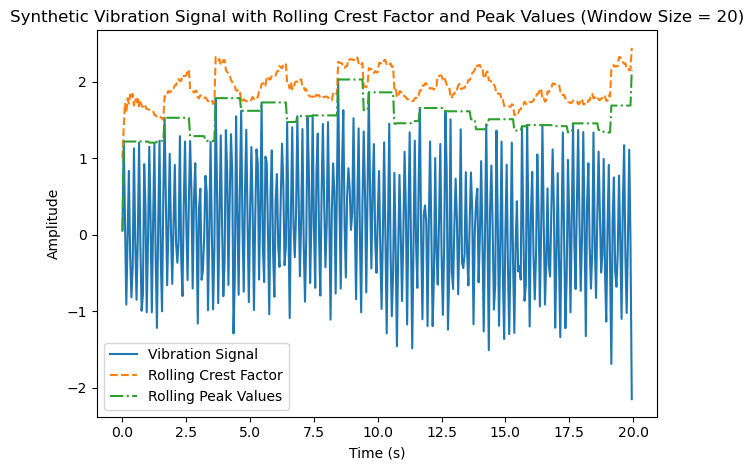

In [37]:
# Plot the vibration signal, rolling Crest Factor, and Peak values

plt.plot(
    time[: len(rolling_crest_factor)],
    vibration_signal[: len(rolling_crest_factor)],
    label="Vibration Signal",
)
plt.plot(
    time[: len(rolling_crest_factor)],
    rolling_crest_factor,
    label="Rolling Crest Factor",
    linestyle="--",
)
plt.plot(
    time[: len(rolling_peak_values)],
    rolling_peak_values,
    label="Rolling Peak Values",
    linestyle="-.",
)
plt.title(
    f"Synthetic Vibration Signal with Rolling Crest Factor and Peak Values (Window Size = {window_size})"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()

Imagine `RMS` and `CF` as a dynamic duo in signal analysis. `RMS` is like the overall strength expert, giving you a big-picture view by crunching numbers. It squares, averages, and roots to show how intense the signal is. Now, meet, the peak detective. It focuses on the spiky parts of the signal, pointing out where things get really high. Together, they make a cool team, helping you understand both the general strength and the sharp peaks in your data.